In [161]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import cmath
from random import randint
from numpy import linalg

L = 0.3/2
c = 340.
T = 2.*L/c
jitt = 0.01*T

#Perceptron parameters
tau_m = 1/T
v_th = 1.
calcSteps = 200

decayFactor = 15.
W_scaling = 1.1

printPerceptron = False
sideImg = 0.7 


In [162]:
# synthetic.py
# --------------
# Copyright : (c) 2019, Germain Haessig <germain@ini.uzh.ch>
# Licence   : BSD3
#
# Generates fake data for the ScarpoCaccia projet.



def generatePositions(angles, radii):
    positions = []
    for r in radii:
        for a in angles:

            u = r*np.cos(a)
            v = r*np.sin(a)

            positions.append([u,v])
            
    return positions

R = [0.3,0.6]
alpha = np.linspace(0.,2*np.pi,num=10, endpoint = False)
positions = generatePositions(alpha,R)

N = len(R)*len(alpha)

In [163]:

angles = [v*2*math.pi/8. for v in range(0,8)]
sensorPositions = [(math.cos(a)*L, math.sin(a)*L) for a in angles]


def singlePositionToSpikes(sensorPositions, preyPosition, jitter = jitt, speed = c):
    posDelays = []
    for sensPos in sensorPositions:
        xdist = sensPos[0] - preyPosition[0]
        ydist = sensPos[1] - preyPosition[1]
        dist = math.sqrt(xdist*xdist + ydist*ydist)
        Dt = dist/speed  + jitter*np.random.rand()
        posDelays.append(Dt)
        
    refTime = min(posDelays)
    #print(posDelays)
    relativeArrival = [pos - refTime for pos in posDelays]
    #print(relativeArrival)
    return relativeArrival
    #return posDelays



In [164]:
def setStartingTimeAtZero(times):
    t_0 = min(times)
    t_list = [t - t_0 for t in times]
    return t_list

In [165]:
def recoverSynapseParamsOnePattern(patternToDetect):
    delays = [T - tp for tp in patternToDetect]
    weights = W_scaling * v_th / len(patternToDetect)*np.ones(len(patternToDetect))
    return (delays, weights)

In [166]:

#EVENT_BASED PERCEPTRON, return detection and max. membrane potential
def LIF_perceptron(synapticDelays, synapticWeights, spikeTimes, T=T):  
    spikeArrival = [synDel + time for synDel, time in zip(synapticDelays, spikeTimes)]

    time = np.linspace(0.,2.5*T,calcSteps)
    spikeBins = np.digitize(spikeArrival,time)
    LIF_input = np.zeros(calcSteps)
    for idx in range(len(synapticDelays)):
        timeBinIdx = spikeBins[idx]
        weight = synapticWeights[idx]
        currentInput = LIF_input[timeBinIdx+1]
        #print('Time = '+str(timeBinIdx)+'  Weight '+ str(weight)+ '  Current Input '+ str(currentInput))
        LIF_input[timeBinIdx+1] =  currentInput + weight
        
    v = 0
    dt = 1/calcSteps

    decay = np.exp(-dt*decayFactor)
    memPot = np.zeros(calcSteps)
    for tIdx in range(calcSteps):
        v = v * decay + LIF_input[tIdx]
        memPot[tIdx] = v

    if printPerceptron == True:
        plt.plot(time, memPot)
        plt.ylabel('V')
        plt.xlabel('Time')
        plt.title('Time perceptron')
        plt.show()
    
    v_max = max(memPot)
    fire = v_max > v_th
    return (fire, v_max)

In [167]:
a_true = 2*math.pi*np.random.rand()
d_true = np.random.rand()*0.6 + 0.4
preyPos = (d_true*math.cos(a_true), d_true*math.sin(a_true))

a_rand = 2*math.pi*np.random.rand()
d_rand = np.random.rand()*0.6 + 0.4
randPos = (d_rand*math.cos(a_rand), d_rand*math.sin(a_rand))

patternToLearn = singlePositionToSpikes(sensorPositions, preyPos)
randomPattern = 0.0005 + np.random.rand(8)*(0.0016)

synDelays, synWeights = recoverSynapseParamsOnePattern(patternToLearn)


truePattern = singlePositionToSpikes(sensorPositions, preyPos)
falsePattern = singlePositionToSpikes(sensorPositions, randPos)
detectTrue, vMaxTrue = LIF_perceptron(synDelays, synWeights, truePattern)
detectFalse, vMaxFalse = LIF_perceptron(synDelays, synWeights, falsePattern)

print('True input: ' + str(detectTrue) + ' with Vmax ' +str(vMaxTrue) + ' Pos: '+str(preyPos))
print('False input: ' + str(detectFalse) + ' with Vmax ' +str(vMaxFalse)+ ' Pos: '+str(randPos))

synchrony = [synD + pattD for synD, pattD in zip(synDelays,truePattern)]
print(sum(synchrony)/T/len(synchrony))
print(sum(synWeights)/len(synWeights))


plt.show()

True input: True with Vmax 1.0212357229795015 Pos: (-0.7000666923911973, 0.6609999272209262)
False input: False with Vmax 0.28652774377885454 Pos: (0.8422403567796215, 0.5356575002527816)
0.9987205527723659
0.13749999999999998


In [168]:
def calibrate(spikePattern):
    speedPropagation = (max(spikePattern) -  min(spikePattern))/L
    TimeWin = 2.*L/c
    return (speedPropagation, TimeWin)

In [169]:
def positionToDelays(preyPos):
    patternToLearn = singlePositionToSpikes(sensorPositions, preyPos)
    synDelays, synWeights = recoverSynapseParamsOnePattern(patternToLearn)
    return synDelays

def delaysPerPosition(positionsList, speed = c):
    timeWind = 2.*L/speed
    delays = [positionToDelays(pos) for pos in positionsList]
    return delays

def findDetector(spikePattern, synDelays, synWeights):
    firingNeurons = []
    v_max_list = []
    for n in range(N):
        fired, vmax = LIF_perceptron(synDelays[n], synWeights[n], spikePattern)
        if fired:
            firingNeurons.append(n)
            v_max_list.append(vmax)
            
        #print(v_max_list)
    #print(v_max_list)
    
    return firingNeurons


weights = [W_scaling * v_th / 8.  for i in range(8)]
weightsDetector = [weights for n in range(N)]
delaysDetector = delaysPerPosition(positions)

idxToDetect = randint(1,N)
#print(len(positions))
positionToDetect = positions[idxToDetect]
spikePattern = singlePositionToSpikes(sensorPositions, positionToDetect)

posIdx = findDetector(spikePattern, delaysDetector, weightsDetector)

print('Actual position: ('+ str(positionToDetect[0]) +' , '+ str(positionToDetect[1]))
for p in posIdx:
    print('Inferred position: ('+ str(positions[p][0]) +' , '+ str(positions[p][1]))
print(len(posIdx))

Actual position: (0.09270509831248416 , -0.2853169548885461
Inferred position: (0.09270509831248416 , -0.2853169548885461
1


7
[7]


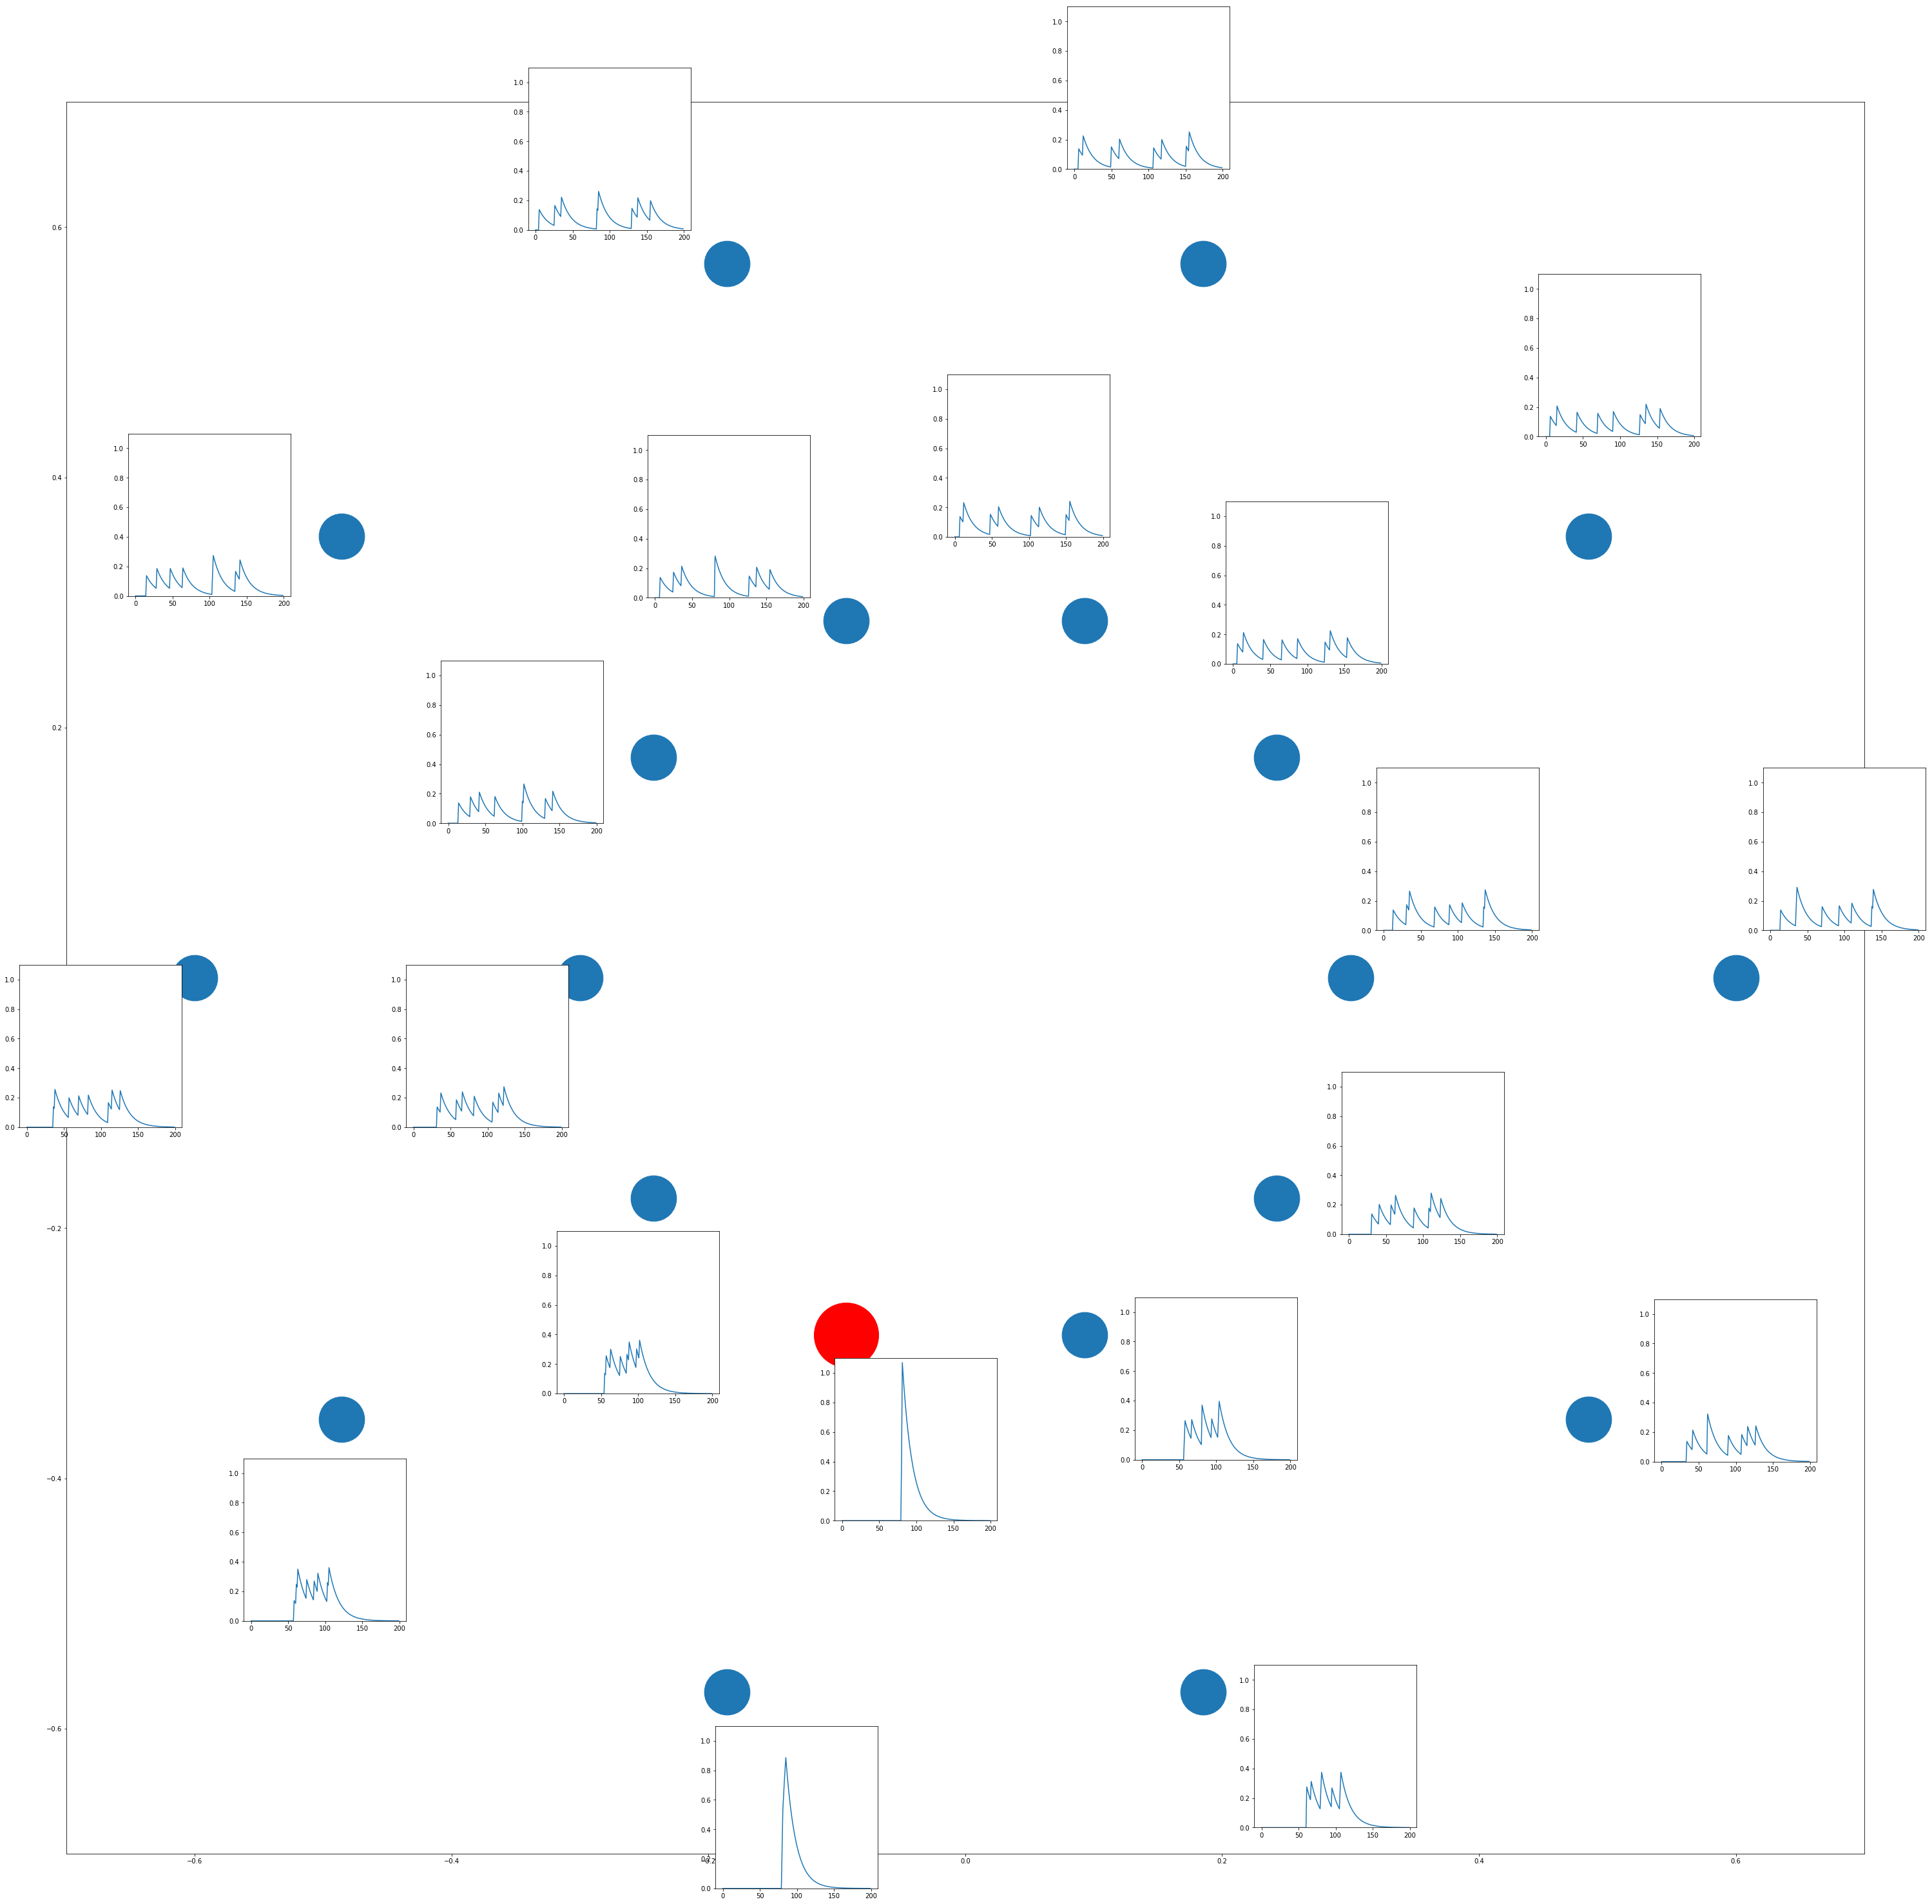

In [199]:
def V_LI(synapticDelays, synapticWeights, spikeTimes, T=T):
    spikeArrival = [synDel + time for synDel, time in zip(synapticDelays, spikeTimes)]

    time = np.linspace(0.,2.5*T,calcSteps)
    spikeBins = np.digitize(spikeArrival,time)
    LIF_input = np.zeros(calcSteps)
    for idx in range(len(synapticDelays)):
        timeBinIdx = spikeBins[idx]
        weight = synapticWeights[idx]
        currentInput = LIF_input[timeBinIdx+1]
        #print('Time = '+str(timeBinIdx)+'  Weight '+ str(weight)+ '  Current Input '+ str(currentInput))
        LIF_input[timeBinIdx+1] =  currentInput + weight
        
    v = 0
    dt = 1/calcSteps

    decay = np.exp(-dt*decayFactor)
    memPot = np.zeros(calcSteps)
    for tIdx in range(calcSteps):
        v = v * decay + LIF_input[tIdx]
        memPot[tIdx] = v

    return memPot

def plotLI(synapticDelays, synapticWeights, spikeTimes, T=T):  
    memPot = V_LI(synapticDelays, synapticWeights, spikeTimes)
    if printPerceptron == True:
        plt.plot(time, memPot)
        plt.ylabel('V')
        plt.xlabel('Time')
        plt.show()
    
def plotPositions(positions, selectedPos = []):
    
    plt.figure(figsize=(50,50))
    x_pos = [p[0] for p in positions]
    y_pos = [p[1] for p in positions]
    plt.scatter(x_pos,y_pos,s=5000)
    if selectedPos:
        x_pos_sel = [p[0] for p in selectedPos]
        y_pos_sel = [p[1] for p in selectedPos]
        plt.scatter(x_pos_sel, y_pos_sel, c='r', s=10000)
    
    plt.show()


    
def positionToImgCoordinates(x,y):
    phi = np.arctan2(y, x)
    x_img = 0.5 + (x-0.035)/1.8 + 0.06*np.cos(phi+math.pi/4)
    y_img = 0.5 + (y-0.035)/1.8 + 0.06*np.sin(phi+math.pi/4)
    return (x_img, y_img)
    
def plotPositionsWithMemPot(positions, selectedPos = [], memPotentials = []):
    plt.figure(figsize=(50,50))
    x_pos = [p[0] for p in positions]
    y_pos = [p[1] for p in positions]
    plt.scatter(x_pos,y_pos,s=5000)
    
    x_sel = [p[0] for p in selectedPos]
    y_sel = [p[1] for p in selectedPos]
    plt.scatter(x_sel, y_sel, c='r', s=10000)
    
    plt.axis([-sideImg,sideImg,-sideImg, sideImg])
    
    memCount = 0
    for sp in positions:
        x_pos, y_pos = positionToImgCoordinates(sp[0], sp[1])
        a = plt.axes([x_pos, y_pos, .07, .07])
        #print(memPotentials)
        plt.plot(memPotentials[memCount])
        plt.ylim(0,1.1)
        memCount = memCount+1
    
    plt.show()
    
idxToDetect = randint(0,N-1)
positionToDetect = positions[idxToDetect]
spikePattern = singlePositionToSpikes(sensorPositions, positionToDetect)
print(idxToDetect)

indexSelectedPos = findDetector(spikePattern, delaysDetector, weightsDetector)
selectedPos = [positions[idxSel] for idxSel in indexSelectedPos]
print(indexSelectedPos)

spikePatternList = [singlePositionToSpikes(sensorPositions, pos) for pos in positions]

memPotList = [V_LI(delaysDetector[idx], weightsDetector[idx], spikePattern) for idx in range(len(positions)) ]
plotPositionsWithMemPot(positions, selectedPos, memPotList)
